# Análisis de espectro singular (SSA) 
***

### Sinopsis


*__Objetivo:__ Conocer, definir y conceptualizar el análisis de espectro singular.* <br>
*__Herramientas:__ Funciones: Scree diagram, SSA.* <br>

### Introducción 

Singular Spectrum Analysis  (SSA) es una técnica de análisis de series de tiempo fundamentada en el álgebra lineal que, descrito por Hassani (2007) se trata de una técnica poderosa, innovadora y con diversas aplicaciones a problemas prácticos en distintas áreas desde matemáticas y física hasta señales biológicas (Sanei, 2015). De acuerdo con Golyandina (2001) la técnica incorpora elementos de análisis clásico de series de tiempo, estadística multivariable, geometría multivariable, sistemas dinámicos y procesamiento de señales. La idea principal en SSA recae en el concepto de separabilidad de la señal, es decir, descomponer la serie de tiempo como una suma de componentes independientes interpretables, siendo algunos de estas componentes interpretadas como la tendencia de la serie, componentes oscilatorias y ruido estructural. Un entendimiento a profundidad del concepto de separabilidad y de sus implicaciones metodológicas y teóricas provee de una mejor interpretación de las componentes y como resultado una aplicación más robusta de la técnica. 

### Concepto y beneficios

En la actualidad SSA es una herramienta particularmente útil para el análisis de datos con patrones periódicos complejos o tendencias no estacionales, como es el caso de señales de EEG, al ser un método no paramétrico que no requiere asumir propiedades sobre el conjunto de datos tal como la estacionariedad y la normalización. Además de la reconstrucción íntegra de la señal a partir de las componentes independientes extraidas, algunos de los problemas que pueden resolverse empleando SSA son: 

	\ Encontrar tendencias de diferentes resoluciones temporales
	\ Extracción de componentes periódicas
	\ Suavizado de la señal
	\ Extracción de periodicidades con amplitud variante

Siendo el primero de ellos, el de mayor interés en las aplicaciones a series de tiempo biológicas, acompañado de una búsqueda por el filtrado de las señales del ruido y artefactos. Algunas de las aplicaciones de SSA que se han logrado en señales de EEG incluyen: 

	* Mohammadi, Kouchaki \& Sanei (2016) publicaron la aplicación de métodos de SSA como parte del preprocesamiento de datos para mejorar la precisión un clasificador SVM (Support Vector Machine) para la identificación de los dominios tiempo-frecuencia del sueño.
	
    * Hu, Guo, Liu \& Wang (2017) implementaron un análisis de SSA para la extracción de ritmos y remoción de artefactos en señales de EEG.
	
    * Dora, Patro, Rout Biswal \& Biswal (2020) propusieron un algoritmo de SSA en conjunto con una red neuronal recurrente (RNN) para la remoción de artefactos musculares en canales únicos de EEG.


### SSA básico

A continuación se presenta la descripción metodológica teórica para la implementación de un análisis univariable de SSA sobre una serie de tiempo, para el cual consideramos un conjunto de puntos $Y_N = (y_0, \cdots ,y_N-1)$ con suficiente longitud $N \geq 3$ que satisface una fórmula lineal recurrente como nuestra serie de tiempo. La técnica consiste en 4 pasos fundamentales divididos en dos etapas principales, descomposición y reconstrucción. 

#### Primera Etapa: Descomposición

##### 1° Paso - Encamado 

La serie unidemsional $Y_N$ es transformada a una serie multidimensional cuya dimensión es llamada _longitud de ventana_ $L$, el primer parámetro de la técnica. Es decir, se construye una matriz a partir de $K$ vectores columna $x_i$ de longitud $L$ obtenidos del vector de tiempo $Y_N$. Donde  $1 < L \leq N/2$ y $K = N-L+1$. Entonces los vectores columna y la construcción de la matriz se describen como:

$$	x_i := (y_i-1, \cdots , y_{i+L-2})^T \hspace{1cm} 1\leq i \leq K \hspace{1cm} \Rightarrow \mathbf{X} =  \left[ x_1:\cdots : x_k \right]$$

Por lo tanto la matriz construida a partir de la serie de tiempo, llamada _matriz de trayectoria_ se define como:

$$ \mathbf{X} = (x_{ij})^{L,K}_{i,j=1} =
	\begin{bmatrix}
		y_0 & y_1 & y_2 & \cdots & y_{K-1} \\
		y_1 & y_2 & y_3 & \cdots & y_K \\
		y_2 & y_3 & y_4 & \cdots & y_{K+1} \\
		\vdots & \vdots & \vdots & \ddots & \vdots \\
		y_{L-1} & y_L & y_{L+1} & \cdots & y_{N-1}
	\end{bmatrix} $$

La definición de la matríz de trayectoria en Python resulta sensilla anidando ciclos de iteración:

###### Importación de paqueterías

In [21]:
import pandas as pd  #Paq. p-manejo de archivos de datos
import scipy as sc  #Paq. p-análisis numérico 
import numpy as np  #Paq. p-cálculo numérico
import matplotlib   #Paq. p-graficación
import matplotlib.pyplot as plt
import os.path as os #Paq. p-despliegue de ruta
import math
import re

In [2]:
N =1500
x =np.arange(0,1500) #Generamos un vector de datos con valores ordenados N=1500
L = 30 #Establecemos un valor para L 
K = N-L+1 #número de vectores columna generados
X = np.array( [[x[i+j] for j in range(0,L)] for i in range (0,K)] ).transpose() #Matriz de trayectoria
X

array([[   0,    1,    2, ..., 1468, 1469, 1470],
       [   1,    2,    3, ..., 1469, 1470, 1471],
       [   2,    3,    4, ..., 1470, 1471, 1472],
       ...,
       [  27,   28,   29, ..., 1495, 1496, 1497],
       [  28,   29,   30, ..., 1496, 1497, 1498],
       [  29,   30,   31, ..., 1497, 1498, 1499]])

Nótese que la matriz de trayectoria $\mathbf{X}$ es una matriz Hankel, por lo que tiene elementos iguales en sus diagonales tales que los subíndices cumplen $i+j = const.$. Finalmente es importante mencionar que, si $N$ y $L$ son fijos, entonces existe una correspondencia única uno-a-uno entre $\mathbf{X}$ y $Y_N$.

##### 2° Paso - Descomposición en valores singulares (SVD)

Una vez construida la matriz de trayectoria, el siguiente paso es obtener su descomposición en valores singulares, es decir expresar la matriz de trayectoria como una suma de matrices bi-ortogonales de rango 1. Para ello, definimos la matriz de covariancia como $ \mathbf{S} = \mathbf{X} \mathbf{X}^T$  y denoatamos a $\lambda_1, \lambda_2,\cdots,\lambda_L$ como los valores propios de $\mathbf{S}$ tomados en orden decreciente de magnitud tal que $(\lambda_1 \geq \lambda_2 \geq\cdots \geq \lambda_L \geq 0)$ y de forma correspondiente denotamos $U_1, U_2, \cdots, U_L$ al sistema de vectores propios de $\mathbf{S}$ asociados. A partir de la descomposición propia obtenida, definimos a $d = max \left\lbrace i, tq. \lambda_i >0 \right\rbrace$ con $(i = 1, \cdots, d)$, adicionalmente denotamos el siguiente producto vector-matriz:

$$V_i = \mathbf{X}^T \cdot \frac{U_i}{\sqrt{\lambda_i}}$$

A este conjunto de elementos propios obtenidos $U_i, V_i, \sqrt{\lambda_i}$ se le conoce como tripleta propia (_eigentriplet_) y permiten definir a los i-ésimos elementos bi-ortogonales resultantes de SVD como:

$$ \mathbf{X}_i = \sqrt{\lambda_i}U_i V_{i}^{T}$$

Por lo tanto, la descomposición SVD de la matriz de trayectoria se denota como:

$$\mathbf{X} = \mathbf{X}_1 + \mathbf{X}_2 + \cdots + \mathbf{X}_d$$

Donde $\mathbf{X}_i$ son matrices elementales y además es posible notar que si todos los $\lambda_i \neq 0 $, es decir si $\mathbf{S}$ es simétrica, entonces $d= L$.

$$ \therefore \mathbf{X} \rightarrowtail_{SVD} \mathbf{X} = \sum_{i}^{d} \mathbf{X}_i$$ 

Para la implementación en Python, afortunadamente existe un módulo de álgebra lineal dentro de la paquetría de Scipy que permite realizar esta operación.

In [3]:
from scipy import linalg #Módulo de álgebra lineal dentro de  Scipy

In [4]:
linalg?

In [35]:
'''Gracias al módulo de svd obtenemos una lista U con los vectores Ui, un array con los valores singulares si
y una sengunda lista V con los vectores Vi '''
U,s,V = linalg.svd(X) 

In [36]:
U.shape

(30, 30)

In [37]:
s

array([1.80969785e+05, 8.96270352e+02, 4.36620683e-11, 1.80818663e-11,
       1.80818663e-11, 1.80818663e-11, 1.80818663e-11, 1.80818663e-11,
       1.80818663e-11, 1.80818663e-11, 1.80818663e-11, 1.80818663e-11,
       1.80818663e-11, 1.80818663e-11, 1.80818663e-11, 1.80818663e-11,
       1.80818663e-11, 1.80818663e-11, 1.80818663e-11, 1.80818663e-11,
       1.80818663e-11, 1.80818663e-11, 1.80818663e-11, 1.80818663e-11,
       1.80818663e-11, 1.80818663e-11, 1.80818663e-11, 1.80818663e-11,
       1.80818663e-11, 1.48360987e-11])

In [38]:
V.shape

(1471, 1471)

#### Segunda Etapa: Reconstrucción 

##### 3° Paso - Agrupamiento

En este paso, se definen particiones del conjunto de orden $d$ de matrices unitarias obtenidas de la descomposición, en sub-grupos disjuntos de orden $m$ definidos como $I_1,\cdots,I_m$, tal que para cada nuevo grupo $I_k$ le corresponde una nueva matriz $\mathbf{X}_{I_k}$ como resultado de sumar las matrices de ese grupo. 


Entonces $\mathbf{X}_{I_1} = \mathbf{X}_{I_{1,1}}+\cdots + \mathbf{X}_{I_{1,p}}$, es un grupo de longitud $p$ que a su vez define a $\mathbf{X}_{I_m} = \mathbf{X}_{I_{m,1}} + \cdots + \mathbf{X}_{I_{m,p}}$. Por lo tanto, tras la agrupación la representación de la matriz de trayectoria queda reformulada como $\mathbf{X} = \mathbf{X}_{I_1}+ \cdots + \mathbf{X}_{I_m}$. Al proceso de elegir los grupos  $I_1,\cdots,I_m$ se le llama el _agrupamiento de las tripletas propias_ y es el segundo y último parámetro de SSA.


Este paso dentro de SSA esta íntimamente relacionado con su concepto principal, la separabilidad de la señal, que caracteriza que tan bien diferenciados se encuentran los componentes obtenidas de la descomposición. Por ello, es útil obtener información suplementaria de las componentes obtenidas para su correcta identificación y posteriormente una agrupación apropiada que para realizarla es posible generar información complementaria del análisis la cual discutiremos más adelante. Adicionalmente, es importante mencionar que en términos prácticos el agrupamiento puede realizarse sobre las series de tiempo en lugar que las matrices ya que éstas presentan una mejor alternativa para lograr un buen agrupamiento gracias a la información complementaria; recordemos que el agrupamiento es una decisión arbitraria del análisis, sin embargo su elección puede afectar la interpretación final de las componentes extraídas.

##### 4° Paso Promediación Diagonal

En el último paso, se transforman las matrices resultantes del paso anterior en las componentes finales para la reconstrucción de la señal como un conjunto de series de tiempo independientes entre si. Esta transformación se logra mediante una operación lineal, conocida como _promediación diagonal_. Para definirla consideramos, sea $\mathbf{Y}$ una matriz de dimensión $L \times K$ con elementos $y_{i,j}$ con $1 \leq i \leq L$ y $ 1\leq j \leq K$, donde si $L<K$ entonces $y^*_{i,j} = y_{i,j}$. Definimos los siguientes parámetros $L^* = min(L,K)$ y $K^*=max(L,K)$ y $N=L+K-1$. Entonces sea $\mathbf{Y}$ la matriz a transformar en la serie $y(g_0,\cdots,g_{N-1})$ se calculan los elementos $g_k$ como:

$$g_k = \left\lbrace \begin{array}{c
			cc}
						\frac{1}{k+1} \sum_{m=1}^{k+1} y^*_{m,k-m+2} & si & 0\leq k <L^*-1 \\ 
						\\
						\frac{1}{L^*} \sum_{m=1}^{L^*} y^*_{m,k-m+2} & si & L^*-1 \leq k < K^* \\
						\\
						\frac{1}{N-k} \sum_{m=k-K^*+2}^{N-K^*+1} y^*_{m,k-m+2} & si & K^*\leq k<N
						\end{array}
				\right. $$
                
La última expresión corresponde a la promediación de los elementos de matriz sobre las "diagonales" tales que $i+j = k+2$. Por ejemplo:

$$	k = 0 \rightarrow g_0=y_{11} \\
	k = 1 \rightarrow g_1=\frac{1}{2}(y_{12}+y_{21}) \\
    \vdots$$
    
Por lo tanto, si $\mathbf{Y}$ es la matriz de trayectoria de una cierta serie $(h_0,\cdots,h_{N-1})$ (es decir, $\mathbf{Y}$ es una matriz Hankel) entonces los elementos obtenidos $g_i$ resultan ser exactamente iguales a $h_i$ para toda $i$. Sin embargo, usualmente las matrices obtenidas de la descomposición $\mathbf{X}_j$ no siempre resultan en matrices Hankel resultando en reconstrucciones aproximadas de $\mathbf{X}$. Para subyacer esta situación un paso adicional en la reconstrucción implica la _Hankelización_ de las matrices $\mathbf{X}_j$ previo a la promediación diagonal para así obtener reconstrucciones precisas de la serie de tiempo. Mediante el proceso de Hankelización sobre las matrices unitarias la descomposición se reescribe como:

$$ \mathbf{X} = \tilde{\mathbf{X}}_{I_1}+\cdots+\tilde{\mathbf{X}}_{I_m}$$

donde $\tilde{\mathbf{X}}_{I_l} = \mathcal{H}\mathbf{X}_{I_l}$ con $\mathcal{H}$ el operador que denota la Hankelización de una matriz. Finalmente cada matriz $\tilde{\mathbf{X}}_{I_k}$ esta unicamente definida y determina una serie de tiempo $\tilde{F}^{(k)} = (\tilde{f}_0^{(k)}, \cdots,\tilde{f}_{N-1}^{(k)})$ por lo que la descomposición de la serie original de tiempo resulta: 

$$y_n = \sum_{k =1}^{m} \tilde{f_n}^{(k)} \\
	\therefore Y_N = \sum_{k=1}^{m} \tilde{F}^{(k)}$$
    
A continuación se presenta una función en Python para realizar SSA sobre una serie de tiempo, dado un parámetro $L$ que arrojará un conjunto de series independientes para su posterior agrupación e interpretación; así como la lista de valores propios obtenidos de SVD.

In [9]:
def SSA_p(signal, L):
    '''PREPARACIÓN - Obtenemos el número de elementos de la señal y de vectores columna'''
    N = len(signal) #no. de puntos de la señal
    K = N-L+1  #no. de columnas de la matriz
    '''ENCAMADO - Obtención de la matriz de trayectoria'''
    X = np.array([[signal[i+j] for j in range(0,L)] for i in range(0,K)]) #Matriz de Trayectoria
    '''SVD - Descomposición'''
    U,s,V = linalg.svd(X) #Aplicación del módulo linalg para la descomposicón SVD
    G = len(s) #no. de eigentripletas
    l = s**2 #Valores propios ó varianzas parciales
    X_elem = [] #Lista auxiliar donde se almacenarán las eigentripletas
    gkList = np.zeros(shape=(G,N)) #array de 2D donde se registrarán las G componentes de N puntos a obtener 
    for k in range(0,G):
        Uk = U[:,k] #Vector U de la eigentripleta k
        Vk = V[k,:] #Vector V de la eigentripleta k 
        X_k = s[k]*np.outer(Uk,Vk) #Calculo de la eigentripleta k
        X_elem.append(X_k) #Añadimos la eigentripleta  k a la lista
        '''PROMEDIACIÓN DIAGONAL - de eigentripletas a vectores'''
        gk = [] #lista auxiliar donde se almacenarán las series de tiempo of values of time series
        for i in range(min(K-1,L-1),-max(K-1,L-1)-1,-1): # loop sobre las diagonales
            gki=np.mean(np.diag(np.fliplr(X_k),i)) #Promediación diagonal - valores sucesivos de la serie de tiempo
            gk.append(gki) #Añadimos la serie a la lista
        gkList[k]=gk #Registramos la serie en el array de series de tiempo
    return (l, gkList) #La función arroja una lista de los valores propios y el array que contiene la series de la descomposición

### Información Suplementaria

Como se mencionó, para el agrupamiento dentro de SSA es útil emplear información suplementaria que puede provenir del análisis de los valores singulares $\sqrt{\lambda_i}$ y de la correlación entre las componentes $\tilde{F}^{(k)}$. Esta información puede ser proporcionada por dos elementos importantes en SSA, el diagrama de dispersión (_scree diagram_) y la matriz de correlación, respectivamente. 

#### Scree Diagram - Inspección de valores singulares

Dentro de la teoría de SSA es conocido que usualmente cada componente armónica con una frecuencia diferente produce dos tripletas propias con valores singulares similares, por ello es útil generar un gráfico conocido como _scree diagram_ donde se grafican los valores singulares en órden en una escala logarítmica. 

Este tipo de gráfica permite identificar "cortes" en el espectro de valores propios, es decir segmentos del espectro en que los valores cambian muy poco entre si, es decir mesetas explícitas en el espectro indican los números ordinales de tripletas propias emparejadas o agrupables.

Podriamos bien utilizar los valores singulares obtenidos de nuestra función de SSA pero también es posible definir una función específica para obtener el diagrama para evitar realizar todo el análisis:

In [10]:
def ScreeD(signal,L): # La función toma una señal y un parámetro L válido
    '''PREPARACIÓN'''
    N=len(signal)
    K=N-L+1
    '''ENCAMADO'''
    X=np.array([[signal[i+j] for j in range(0,L)] for i in range(0,K)]) # matriz de trayectoria
    Xh = X.transpose() #matriz de trayectoria transpuesta
    S = np.matmul(Xh,X) #Calculo de la matriz cuadrada S
    s=linalg.svd(S,compute_uv=False) # descomposición en valores singulares
    return s

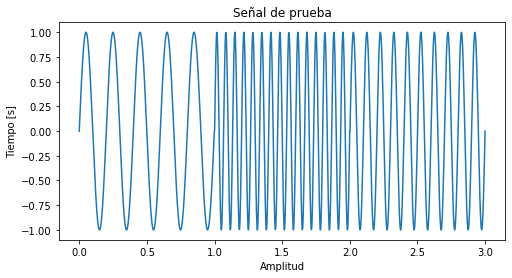

In [11]:
#Generamos una señal de prueba
def probe(f1,f2,f3,time):
    #Definimos las tres señales oscilatorias con frecuencias distintas
    s1 = np.sin(2*np.pi*f1*time)
    s2 = np.sin(2*np.pi*f2*time)
    s3 = np.sin(2*np.pi*f3*time)
    dummy = np.concatenate((s1,s2,s3)) #Concatenamos las tres señales obteneindo una nueva señal del triple de duración
    return dummy 
s_time = np.linspace(0,1,500) #Vector de tiempo de cada señal individual
fig, ax = plt.subplots(1,figsize=(8,4))

time = np.linspace(0,3,1500) #Vector de tiempo de la señal resultante
test = probe(5,15,10,s_time)
ax.plot(time,test)
ax.set_title('Señal de prueba')
ax.set_ylabel('Tiempo [s]')
ax.set_xlabel('Amplitud')
plt.show()

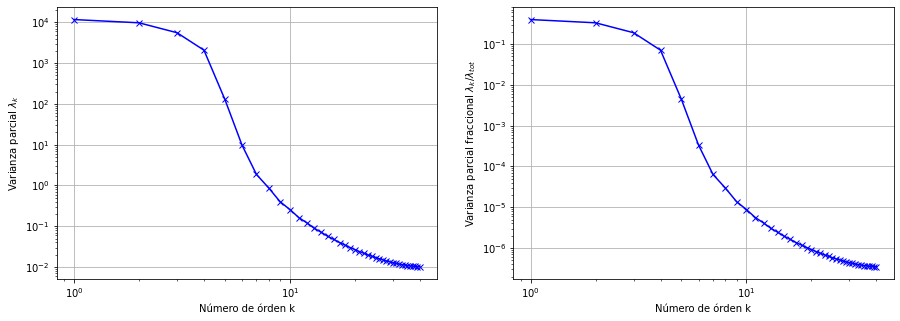

In [12]:
L=40
l=ScreeD(test,L)
k=np.arange(len(l))
k=k+1
fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(k,l,'-x',color='blue')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('Número de órden k')
axs[0].set_ylabel(r'Varianza parcial $\lambda_k$')
axs[0].grid()

axs[1].plot(k,l/sum(l),'-x',color='blue')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Número de órden k')
axs[1].set_ylabel(r'Varianza parcial fraccional $\lambda_k/\lambda_{tot}$')
axs[1].grid()
plt.show()

#### Matriz de correlación y la separabilidad

Sabemos que la descomposición SSA de una serie $Y$ es exitosa si las resultantes componentes aditivas son aproximadamente separables entre ellas. Una medida del nivel de separabilidad entre estas componentes aditivas es la correlación ponderada _w-correlation_) que es una medida natural $\rho_{12}^{(w)}$ de la dependencia de 2 series, sean $F_N^{(1)}$ y $F_N^{(2)}$, definida como:

$$ \rho_{12}^{(w)} = \frac{(F_N^{(1)},F_N^{(2)})_w}{|| F_N^{(1)}||_{w} ||F_N^{(2)}||_{w}}	 $$

donde $||F_N^{(i)}||_{w} = \sqrt{(F_N^{(i)},F_N^{(i)})_w}$ y $(F_N^{(i)},F_N^{(j)})_w=\sum_{k =1}^{N} w_{k}f_{k}^{(i)} f_{k}^{(j)}$ con $w_k = min\left\lbrace k,L,N-k \right\rbrace$

La forma de interpretar esta medida se determina de acuerdo al valor absoluto de $\rho_{12}^{(w)}$, si este valor es pequeño, entonces la series correspondientes son cercanamente ortogonales respecto al peso $w$, es decir, son separables, siendo el caso límite en el que el valor $w-correl =0$ implica que las dos series son completamente separables. Finalmente si el valor $w-correl$ es amplio se interpreta que las componentes deberian posiblemente ser agrupadas en como una sola y corresponden a una misma componente aditiva de SSA. 

Para concluir, integraremos la obtención de la matriz de correlación a nuestra función de SSA, la cual se generará entre los pares de las componentes extraidas de la señal.

In [39]:
def SSA(signal, L):
    '''PREPARACIÓN - Obtenemos el número de elementos de la señal y de vectores columna'''
    N = len(signal) #no. de puntos de la señal
    K = N-L+1  #no. de columnas de la matriz
    '''ENCAMADO - Obtención de la matriz de trayectoria'''
    X = np.array([[signal[i+j] for j in range(0,L)] for i in range(0,K)]) #Matriz de Trayectoria
    '''SVD - Descomposición'''
    U,s,V = linalg.svd(X) #Aplicación del módulo linalg para la descomposicón SVD
    G = len(s) #no. de eigentripletas
    l = s**2 #Valores propios ó varianzas parciales
    X_elem = [] #Lista auxiliar donde se almacenarán las eigentripletas
    gkList = np.zeros(shape=(G,N)) #array de 2D donde se registrarán las G componentes de N puntos a obtener 
    for k in range(0,G):
        Uk = U[:,k] #Vector U de la eigentripleta k
        Vk = V[k,:] #Vector V de la eigentripleta k 
        X_k = s[k]*np.outer(Uk,Vk) #Calculo de la eigentripleta k
        X_elem.append(X_k) #Añadimos la eigentripleta  k a la lista
        '''PROMEDIACIÓN DIAGONAL - de eigentripletas a vectores'''
        gk = [] #lista auxiliar donde se almacenarán las series de tiempo of values of time series
        for i in range(min(K-1,L-1),-max(K-1,L-1)-1,-1): # loop sobre las diagonales
            gki=np.mean(np.diag(np.fliplr(X_k),i)) #Promediación diagonal - valores sucesivos de la serie de tiempo
            gk.append(gki) #Añadimos la serie a la lista
        gkList[k]=gk #Registramos la serie en el array de series de tiempo
    '''MATRIZ DE CORRELACIÓN'''
    w=[] # Lista auxiliar donde se almacenarán los valores de los pesos
    #Cotas para el índice 
    LL=min(L,K)
    KK=max(L,K)
    for ll in range(1,LL+1): # primero tercio 
        w.append(ll)
    for ll in range(LL+1,KK+1): # segundo tercio
        w.append(LL)
    for ll in range(KK+1,N+1): # tercer tercio
        w.append(N-ll)
    kMin=kkMin=0 # Establecemos que se muestre la matriz de correlación solo para las primeras 20 componentes 
    if L >= 20:
        kMax=kkMax=20
    else:
        kMax=kkMax=L
    #Cálculo de la matris de correlación
    wMatriz=[[sum(w*gkList[k]*gkList[kk])/(math.sqrt(sum(w*gkList[k]*gkList[k]))*math.sqrt(sum(w*gkList[kk]*gkList[kk]))) for k in range(kMin,kMax)] for kk in range(kkMin,kkMax)]
    wMatriz=np.array(wMatriz)
    return (l, gkList, wMatriz) #Añadimos la matriz de correlación a los resultados

### Referencias

    1. Hassani, H. (2007). Singular spectrum analysis: methodology and comparison.
    
    2. Sanei, S., & Hassani, H. (2015). Singular spectrum analysis of biomedical signals. CRC press.
    
    3.Golyandina, N., Nekrutkin, V., & Zhigljavsky, A. A. (2001). Analysis of time series structure: SSA and related techniques. CRC press.
    
    4. Mohammadi, S. M., Kouchaki, S., Ghavami, M., & Sanei, S. (2016). Improving time–frequency domain sleep EEG classification via singular spectrum analysis. Journal of neuroscience methods, 273, 96-106.
    
    5. Hu, H., Guo, S., Liu, R., & Wang, P. (2017). An adaptive singular spectrum analysis method for extracting brain rhythms of electroencephalography. PeerJ, 5, e3474.
    
    6. Dora, C., Patro, R. N., Rout, S. K., Biswal, P. K., & Biswal, B. (2020). Adaptive SSA Based Muscle Artifact Removal from Single Channel EEG using Neural Network Regressor. IRBM.